<h1>Using A Machine Learning Model to Predict Whether an Individual's Income Is Above or Below $50,000</h1>


In [246]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve, auc,f1_score,cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

<h2>1. Opening Dataset</h2>

<h3>1.1 Opening Data</h3>
Loading the Datasets, they were already split into test and train so i will recombine them and format them and then do the split later.

In [247]:
#the Dataset i have chosen has the data split into 2 sections, one for training and one for testing.
#I will merge them together so that I can choose a test train split myself later.
df1 = pd.read_csv("./adult/adult.data")
df2 = pd.read_csv("./adult/adult.test")

columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex","capital-gain","capital-loss","hours-per-week","native-country","label"]
df1.columns = df2.columns = columns

df = pd.concat([df1,df2])

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


<h3>1.2 Exploratory Data Analysis</h3>
Getting an outline of the data so I know how to best process it later. looking at what types of data each feature contains and how many categories they have

In [248]:
print(f"Size: {len(df)}\n\nEmpty Values:\n{df.isna().sum()}\n")
print(df["label"].value_counts(normalize=True)*100)


Size: 48840

Empty Values:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
label             0
dtype: int64

label
 <=50K     50.612203
 <=50K.    25.458640
 >50K      16.054464
 >50K.      7.874693
Name: proportion, dtype: float64


In [249]:
#Count of unique values in each categorical column
cat_columns = df.select_dtypes(include=["object"]).columns
for col in cat_columns:
    print(f"\n{col} distribution:")
    print(df[col].value_counts(normalize=True)*100)


workclass distribution:
workclass
 Private             69.420557
 Self-emp-not-inc     7.907453
 Local-gov            6.420966
 ?                    5.730958
 State-gov            4.054054
 Self-emp-inc         3.470516
 Federal-gov          2.932023
 Without-pay          0.042998
 Never-worked         0.020475
Name: proportion, dtype: float64

education distribution:
education
 HS-grad         32.317772
 Some-college    22.272727
 Bachelors       16.429156
 Masters          5.440213
 Assoc-voc        4.219902
 11th             3.708026
 Assoc-acdm       3.278051
 10th             2.843980
 7th-8th          1.955364
 Prof-school      1.707617
 9th              1.547912
 12th             1.345209
 Doctorate        1.216216
 5th-6th          1.042179
 1st-4th          0.505733
 Preschool        0.169943
Name: proportion, dtype: float64

marital-status distribution:
marital-status
 Married-civ-spouse       45.821048
 Never-married            32.995495
 Divorced                 13.581081


No empty cells to deal with

<h2>2. Feature Formatting</h2>
-Converting all categorical Data into numbers that are usable for the model and merging similar categories,<br>
-Merging features to simplify categories for the model,<br>
-Extracting and creating new features from existing features

<h3>2.1 Labels</h3>
Formatting the labels first to help with formatting other features later
<li>Merging categories together</li>
<li>Converting to int where 0 is <50k and 1 is >50k </li>

<Axes: title={'center': 'Count for Label'}, xlabel='Label', ylabel='Count'>

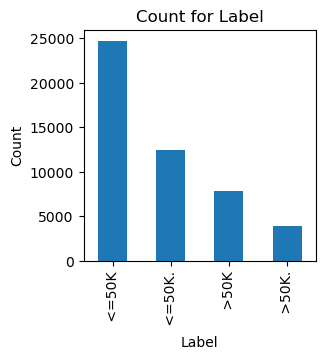

In [250]:
df["label"].value_counts().plot(kind="bar",
                                figsize=(3,3),
                                ylabel="Count",
                                xlabel="Label",
                                title="Count for Label")

In [251]:
df["label"].unique()

array([' <=50K', ' >50K', ' <=50K.', ' >50K.'], dtype=object)

In [252]:
#Merging all the "<=50k." and "<=50K" and same with ">50k" and ">50k."
df["label"].replace({" <=50K.":"<=50K",
                 " >50K.":">50K",
                 " <=50K":"<=50K",
                 " >50K":">50K"},inplace=True)


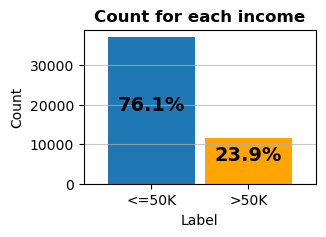

In [253]:
label_counts = df["label"].value_counts()

(df["label"].value_counts()).plot(kind="bar", figsize=(3, 2), color=["orange" if label == ">50K" else "#1f77b4" for label in label_counts.index],width=0.9)

plt.title("Count for each income",fontweight="bold")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)

#Add y-axis lines
plt.grid(axis="y",  alpha=0.7)

#Add percentages on top of the bars
total = len(df["label"])
for i, count in enumerate(df["label"].value_counts()):
    percentage = (count / total) * 100
    plt.text(i, count/2, f"{percentage:.1f}%", ha="center", fontsize=14, fontweight="bold")


plt.show()

In [254]:
df["label"].value_counts(normalize=True) * 100

label
<=50K    76.070844
>50K     23.929156
Name: proportion, dtype: float64

<h4>2.2.1 labelPlot Function</h4>
defining a function to plot a stacked barchart of a column grouped by the label this will be used just for me making decisions and will none of these charts will be in the report

In [255]:
def labelPlot(column, df, title,  figsize=(12, 6), width=0.8):
    #Group data by "age" and "label" and calculate counts
    grouped_data = df.groupby([column, "label"]).size().unstack()

    #Create a grouped bar chart with adjusted bar width
    ax = grouped_data.plot(kind="bar", figsize=figsize, width=width)

    #Label the axes
    plt.xticks(rotation=45, ha="right")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.title(title)

    #Adding grid
    plt.grid(axis="y", zorder=1, alpha=0.5)

    #Display the legend
    plt.legend(title="Income", loc="upper right", labels=["<=50K", ">50K"])

    #Show the plot
    plt.show()


<h4>2.2.1 labelPercentagePlot Function</h4>
defining a function to plot a stacked barchart of each category for a given attribute as a percentage based off the label

In [256]:
def labelPercentagePlot(column, df, figsize=(12, 6),by="<=50K",title="",sort=True,width=0.8):
    #Group data by the specified attribute and label, and calculate counts
    grouped_data = df.groupby([column, "label"]).size().unstack()

    #Normalize data to percentages and sort
    grouped_data_percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0) *100
    print(grouped_data_percentages)
    if sort:
        grouped_data_percentages = grouped_data_percentages.sort_values(by=by)

    #Create a stacked bar chart
    ax = grouped_data_percentages.plot(kind="bar", stacked=True, figsize=figsize,width=width)

    #Label the axes
    plt.xticks(rotation=45, ha="right")
    plt.xlabel(column)
    plt.ylabel("Percentage")
    plt.title(title)

    plt.grid(axis="y")

    #Display the legend
    plt.legend(title="Income", loc="lower right", labels=["<=50K", ">50K"])

    #Show the plot
    plt.show()


<h3>2.2 age</h3>
Formatting the age column by:
<li>binning ages into categories


In [257]:
#saving the age to compare after formatting
age_before = pd.DataFrame()
age_before["age"] = df["age"].copy()
age_before["label"] = df["label"].copy()

In [258]:
#the bins and order of the bins by age
age_bins = [17, 22, 29, 34, 44, 55, 61, 100]
age_categories = {"Students":0, "Entry level worker":1, "Young professional":2, "Established professional":3,
              "Mid-career professional":4, "Experienced professional":5, "Retired":6}

#Create a new column "Age Category" in the DataFrame
df["age"] = pd.cut(df["age"], bins=age_bins, labels=age_categories.keys(), right=False)

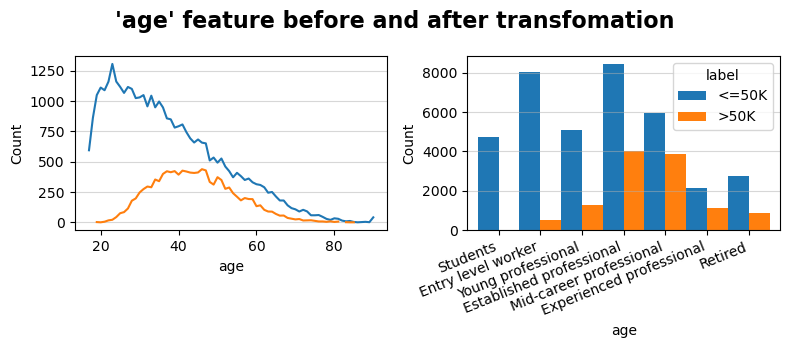

In [259]:
#Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3.5))
fig.suptitle("'age' feature before and after transfomation",fontweight="bold",fontsize=16)

#Plot the continous age before
grouped_data2 = age_before.groupby(["age", "label"]).size().unstack()
ax2 = grouped_data2.plot(kind="line", ax=axes[0],legend=False)
ax2.set_xlabel("age")
ax2.set_ylabel("Count")
ax2.grid(axis="y", zorder=1, alpha=0.5)
#ax2.legend(title="Income", loc="upper right", labels=["<=50K", ">50K"])


#Plot the categorical age after
grouped_data1 = df.groupby(["age", "label"]).size().unstack()
ax1 = grouped_data1.plot(kind="bar", ax=axes[1], width=1)
ax1.set_xlabel("age")
ax1.set_ylabel("Count")
ax1.grid(axis="y", zorder=1, alpha=0.5)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=22, ha="right")

plt.tight_layout()
plt.show()

<h3>2.3 workclass</h3>
merged together the categories to reduce noise

label                   <=50K       >50K
workclass                               
 ?                  90.532333   9.467667
 Federal-gov        60.824022  39.175978
 Local-gov          70.440051  29.559949
 Never-worked      100.000000        NaN
 Private            78.212653  21.787347
 Self-emp-inc       44.660767  55.339233
 Self-emp-not-inc   72.112895  27.887105
 State-gov          73.232323  26.767677
 Without-pay        90.476190   9.523810


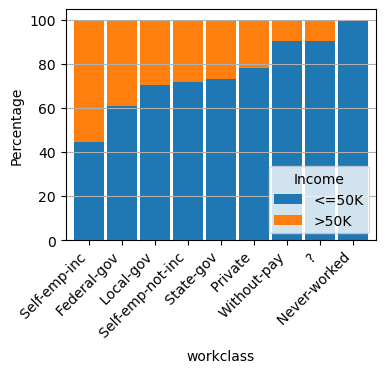

In [260]:
labelPercentagePlot("workclass",df,(4,3),sort=True,width=0.9)

remove the never worked category and no pay, it was too small and people who have never worked are likely to be people who are retired or studnets and so their income will already be known
Merging local government state government and Federal government as they are similar in their labeling and they also are both goevernment organizations and so both will have similar pay structure for employees.

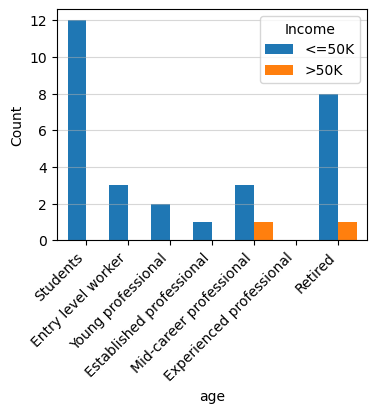

In [261]:
labelPlot("age",df[df["workclass"].isin([" Without-pay"," Never-worked"])],"",(4,3),width=0.9)

In [262]:
#merging classes
df["workclass"].unique()
mergeWorkClasses = {" Local-gov":"Gov",
                    " State-gov":"Gov",
                    " Federal-gov":"Gov"}

df["workclass"] = df["workclass"].replace(mergeWorkClasses)

#removing the Never-worked category
df = df[df["workclass"] != " Never-worked"]
#removing without pay
df = df[df["workclass"] != " Without-pay"]

In [263]:
df["workclass"].value_counts()

workclass
 Private             33905
Gov                   6548
 Self-emp-not-inc     3862
 ?                    2799
 Self-emp-inc         1695
Name: count, dtype: int64

<Axes: xlabel='workclass'>

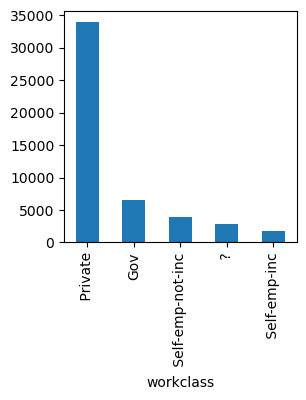

In [264]:
#plotting the workclass
plt.xticks(rotation=45)
df["workclass"].value_counts().plot(kind="bar",figsize=(3,3))

label                  <=50K       >50K
workclass                              
 ?                 90.532333   9.467667
 Private           78.212653  21.787347
 Self-emp-inc      44.660767  55.339233
 Self-emp-not-inc  72.112895  27.887105
Gov                69.181429  30.818571


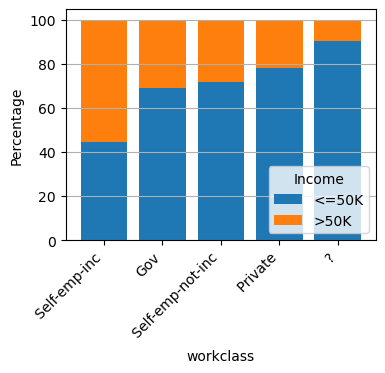

In [265]:
labelPercentagePlot("workclass",df,(4,3))

<h3>2.4 fnlwgt</h3>
fnlwgt is removed as the data seems to be uniform with respect to income

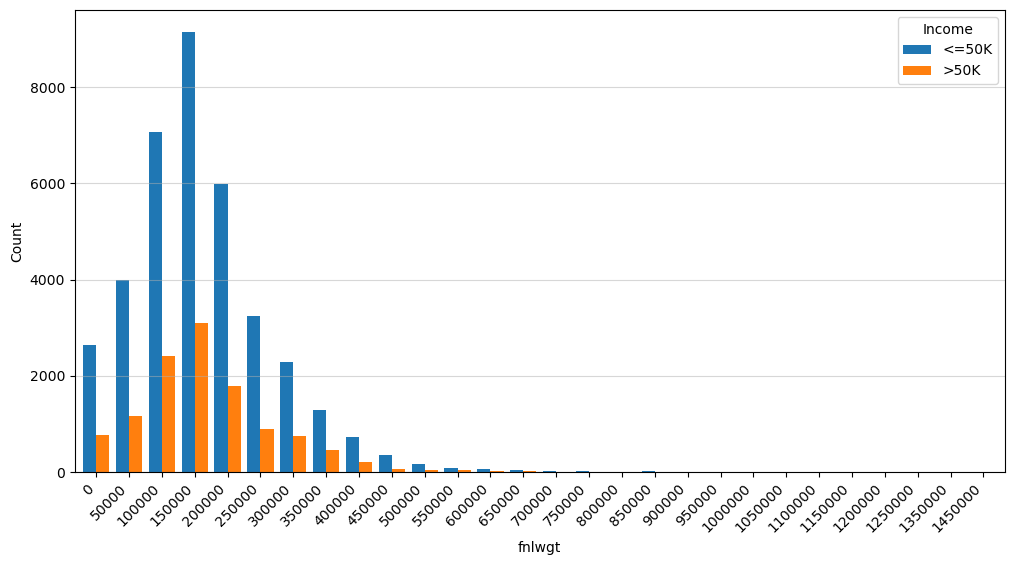

In [266]:
#roughly categorizing the data to make it easier to analyze
df["fnlwgt"] = (df["fnlwgt"] // 50000) * 50000

df["fnlwgt"].value_counts().sort_index()
labelPlot("fnlwgt",df,"")

label         <=50K       >50K
fnlwgt                        
0         77.284749  22.715251
50000     77.639752  22.360248
100000    74.590770  25.409230
150000    74.769105  25.230895
200000    76.987287  23.012713
250000    78.382958  21.617042
300000    75.596817  24.403183
350000    74.204743  25.795257
400000    77.825619  22.174381
450000    83.413462  16.586538
500000    78.217822  21.782178
550000    70.731707  29.268293
600000    77.272727  22.727273
650000    82.352941  17.647059
700000    76.470588  23.529412
750000    77.777778  22.222222
800000    60.000000  40.000000
850000   100.000000        NaN
900000    85.714286  14.285714
950000    75.000000  25.000000
1000000   80.000000  20.000000
1050000   50.000000  50.000000
1100000  100.000000        NaN
1150000  100.000000        NaN
1200000   50.000000  50.000000
1250000  100.000000        NaN
1350000  100.000000        NaN
1450000  100.000000        NaN


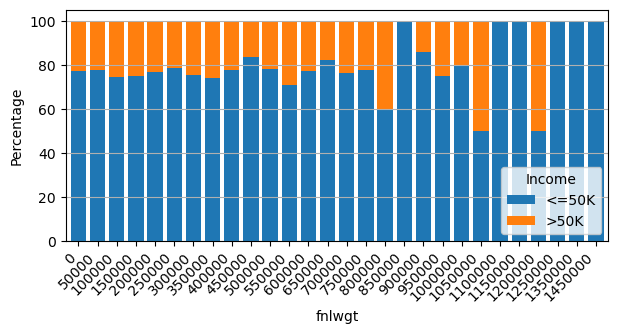

In [267]:
labelPercentagePlot("fnlwgt",df,(7,3),sort=False)

In [268]:
df["fnlwgt"].clip(upper=400000,inplace=True)

In [269]:
df.drop("fnlwgt",axis=1,inplace=True)

<h3>2.5 education-num</h3>
education-num is just the enumerated education column so i will drop it

In [270]:
df.drop("education-num",axis=1,inplace=True)

<h3>2.6 education</h3>
grouping education together for infrequent categories to reduce noise

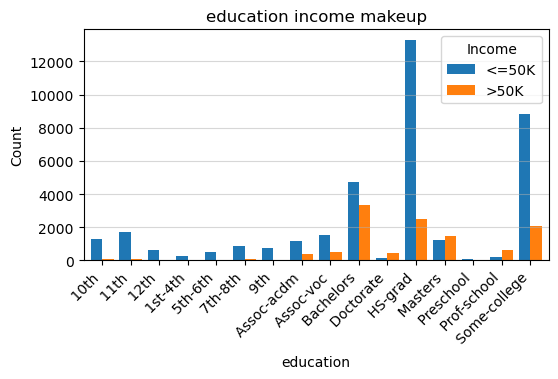

In [271]:
labelPlot("education",df,"education income makeup",(6,3))

<Axes: ylabel='education'>

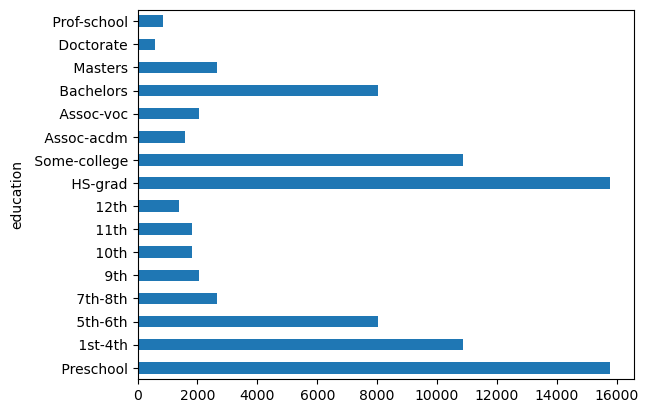

In [272]:
df["education"].value_counts().plot(kind="barh")

#Define the custom order for sorting
education_order = [
    " Preschool",
    " 1st-4th",
    " 5th-6th",
    " 7th-8th",
    " 9th",
    " 10th",
    " 11th",
    " 12th",
    " HS-grad",
    " Some-college",
    " Assoc-acdm",
    " Assoc-voc",
    " Bachelors",
    " Masters",
    " Doctorate",
    " Prof-school"
]

#Reorder the education column based on the custom order
df["education"] = pd.Categorical(df["education"], categories=education_order, ordered=True)

#Plot the horizontal bar chart with the custom order
df["education"].value_counts().sort_index().plot(kind="barh")

education-num is just the education enumerated so i will drop the education-num column

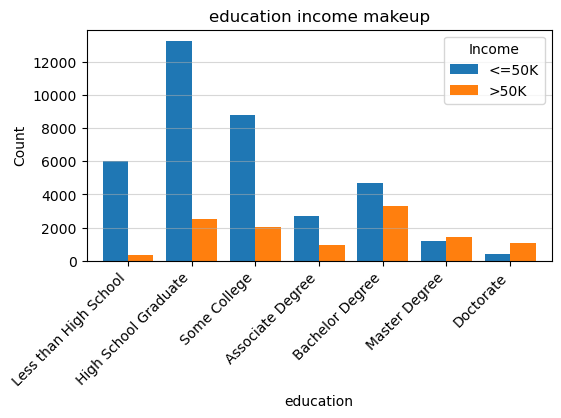

In [273]:
#grouping categories together into
#Non high school gradutes
#High School graduates
#Some college
#Associate Degree
#Bachelors Degree
#Postgraduate Degrees
education_order = {
    " Preschool": "Less than High School",
    " 1st-4th": "Less than High School",
    " 5th-6th": "Less than High School",
    " 7th-8th": "Less than High School",
    " 9th": "Less than High School",
    " 10th": "Less than High School",
    " 11th": "Less than High School",
    " 12th": "Less than High School",
    " HS-grad": "High School Graduate",
    " Some-college": "Some College",
    " Assoc-acdm": "Associate Degree",
    " Assoc-voc": "Associate Degree",
    " Bachelors": "Bachelor Degree",
    " Masters": "Master Degree",
    " Doctorate": "Doctorate",
    " Prof-school": "Doctorate"
}

df["education"] = df["education"].replace(education_order)
labelPlot("education",df,"education income makeup",(6,3))

<h3>2.7 marital-status</h3>
grouping together marital status and merging infrequent groups into never married, married and separated

<Axes: xlabel='marital-status'>

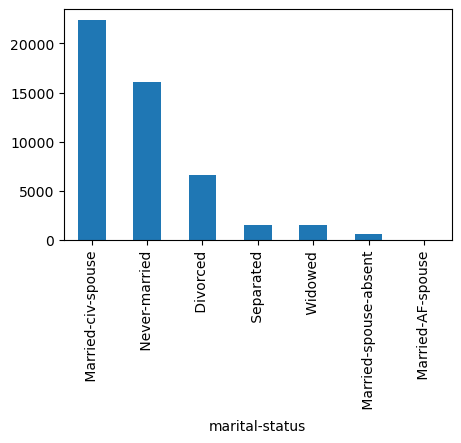

In [274]:
df["marital-status"].value_counts().plot(kind="bar",figsize=(5,3))

label                       <=50K       >50K
marital-status                              
 Divorced               89.882388  10.117612
 Married-AF-spouse      62.162162  37.837838
 Married-civ-spouse     55.367762  44.632238
 Married-spouse-absent  90.734824   9.265176
 Never-married          95.447770   4.552230
 Separated              93.529412   6.470588
 Widowed                91.562294   8.437706


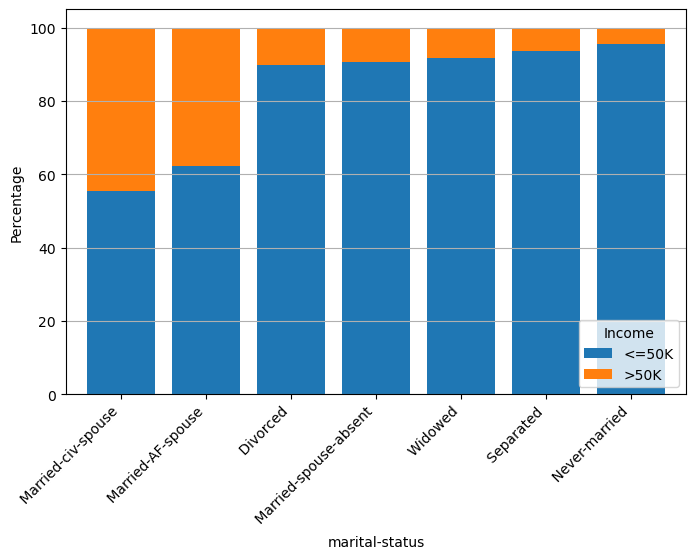

In [275]:
labelPercentagePlot("marital-status",df,(8,5))

there is a clear trend with married people having higher income, due to AF spouse being infrequent and having similar income to civ spouse it makes sense to merge, the same is true of Married-spouse-absent, Widowed separated and Divorced as they are all infrequent, have similar income and are all people who were previously married but are no longer with their partner

In [276]:
df.replace(inplace=True,
           to_replace={
               " Married-AF-spouse":"Married",
               " Married-civ-spouse":"Married",
               
               " Married-spouse-absent":"Separated",
               " Widowed":"Separated",
               " Separated":"Separated",
               " Divorced":"Separated"
           })

label               <=50K       >50K
marital-status                      
 Never-married  95.447770   4.552230
Married         55.378984  44.621016
Separated       90.722950   9.277050


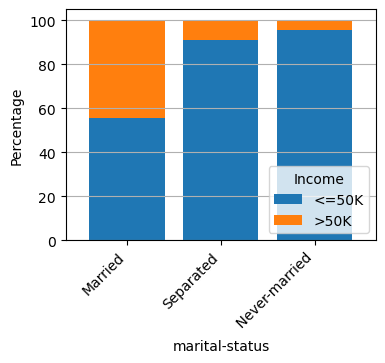

In [277]:
labelPercentagePlot("marital-status",df,(4,3))

<h3>2.8 occupation</h3>
merged the infrequent occupations into similar categories

label                   <=50K       >50K
occupation                              
 ?                  90.532333   9.467667
 Adm-clerical       86.302836  13.697164
 Armed-Forces       66.666667  33.333333
 Craft-repair       77.368679  22.631321
 Exec-managerial    52.210353  47.789647
 Farming-fishing    88.326586  11.673414
 Handlers-cleaners  93.381643   6.618357
 Machine-op-inspct  87.711163  12.288837
 Other-service      95.854501   4.145499
 Priv-house-serv    98.760331   1.239669
 Prof-specialty     54.893065  45.106935
 Protective-serv    68.667345  31.332655
 Sales              73.196438  26.803562
 Tech-support       70.954357  29.045643
 Transport-moving   79.566695  20.433305


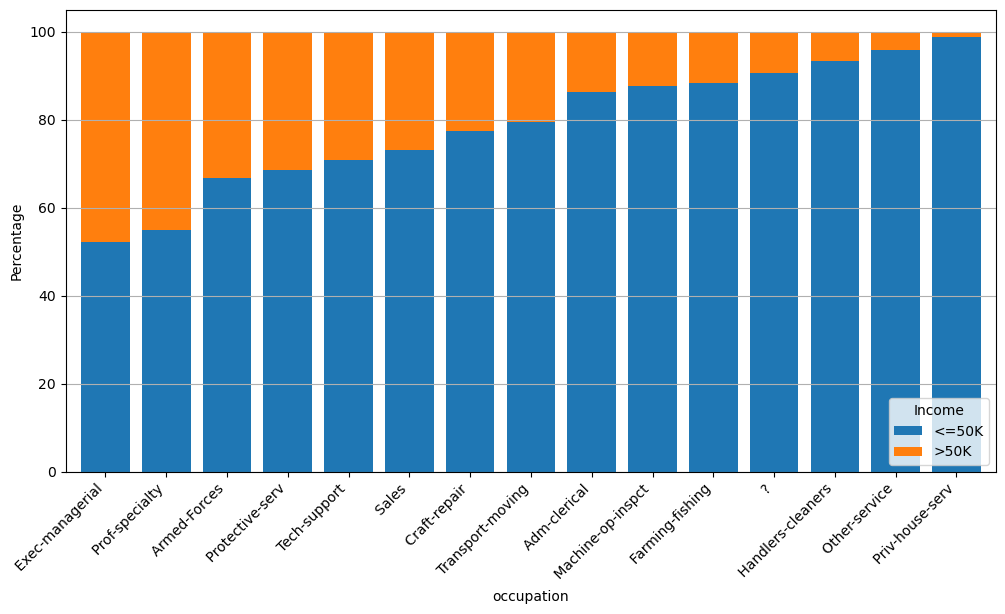

In [278]:
labelPercentagePlot("occupation",df)

In [279]:
df["occupation"].value_counts(normalize=True)*100

occupation
 Prof-specialty       12.645209
 Craft-repair         12.520232
 Exec-managerial      12.466963
 Adm-clerical         11.487635
 Sales                11.274560
 Other-service        10.082157
 Machine-op-inspct     6.185335
 ?                     5.734598
 Transport-moving      4.822881
 Handlers-cleaners     4.241021
 Farming-fishing       3.036325
 Tech-support          2.962568
 Protective-serv       2.013973
 Priv-house-serv       0.495810
 Armed-Forces          0.030732
Name: proportion, dtype: float64

label                  <=50K      >50K
occupation                            
 ?                  0.905323  0.094677
 Armed-Forces       0.666667  0.333333
 Handlers-cleaners  0.933816  0.066184
 Priv-house-serv    0.987603  0.012397
 Protective-serv    0.686673  0.313327


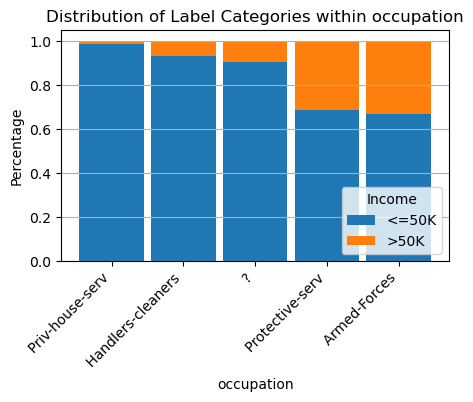

In [280]:
#Group data by the income and occupation
grouped_data = df[df["occupation"].isin([" Handlers-cleaners", " ?", " Priv-house-serv", " Protective-serv", " Armed-Forces"])].groupby(["occupation", "label"]).size().unstack()

#Normalize data to percentages and sort
grouped_data_percentages = grouped_data.div(grouped_data.sum(axis=1), axis=0)
print(grouped_data_percentages)
grouped_data_percentages = grouped_data_percentages.sort_values(by=">50K")

#Create a stacked bar chart
ax = grouped_data_percentages.plot(kind="bar", stacked=True, figsize=(5,3),width=0.9)

#Label the axes
plt.xticks(rotation=45, ha="right")
plt.xlabel("occupation")
plt.ylabel("Percentage")
plt.title(f"Distribution of Label Categories within occupation")

plt.grid(axis="y")

#Display the legend
plt.legend(title="Income", loc="lower right", labels=["<=50K", ">50K"])

#Show the plot
plt.show()

you can see the categories to be merged have similar income and so it makes sense to add the smaller ones to the larger ones instead of grouping into the unknown

In [281]:
df["occupation"].replace({" Priv-house-serv":" Handlers-cleaners",
                          " Armed-Forces":" Protective-serv"},inplace=True)

<h3>2.9 relationship </h3>
relationship data is ambiguous and inaccurate and so i will try to engineer a feature for wether they cohabit or live alone, which should be useful for income as it can tell wether someone can afford bills on their own

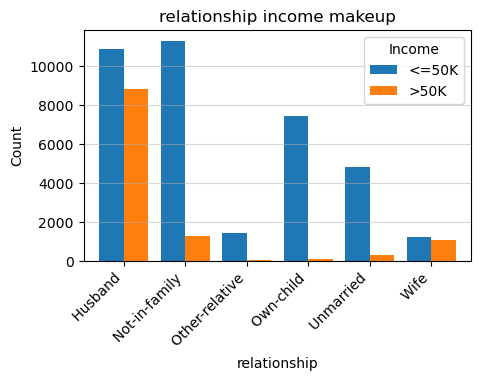

In [282]:
labelPlot("relationship",df,"relationship income makeup",(5,3))

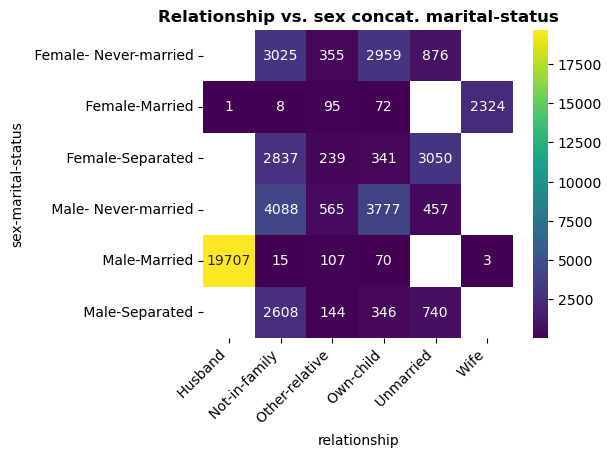

In [283]:
#Create a new DataFrame for sex and marital status concatenated to compare that to the relationship
plotdf = df[["relationship", "sex", "marital-status"]].copy()

#Combine "sex" and "marital-status" into a new column "sex-marital-status"
plotdf["sex-marital-status"] = plotdf["sex"] + "-" + plotdf["marital-status"]

#use a heatmap to compare the count for each relationship to see if it aligns with the sex and marital status
plt.figure(figsize=(5, 4))
heatmap_data = plotdf.groupby(["sex-marital-status", "relationship"]).size().unstack()
sns.heatmap(heatmap_data, annot=True, fmt="g", cmap="viridis", cbar=True)
plt.title("Relationship vs. sex concat. marital-status",fontweight="bold")
plt.xticks(rotation=45, ha="right")
plt.show()

data is unreliable so will categorize into people who live alone or with a family

In [284]:
#making a new colum for living situation
df.rename(columns={"relationship": "living-situation"}, inplace=True)

living_situation_replace = {
    " Husband":"cohabiting",
    " Not-in-family":"live-alone",
    " Wife":"cohabiting",
    " Own-child":"cohabiting",
    " Unmarried":"live-alone",
    " Other-relative":"live-alone"
}
df["living-situation"].replace(living_situation_replace,inplace=True)

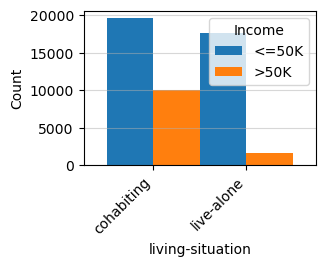

In [285]:
labelPlot("living-situation",df,"",(3,2),width=1)

there is a clear pattern with the new feature but not the one i was expecting, people who cohabit tend to be better off, probably becuase they are older and thus later in their career

<h3>2.10 race </h3>
Race has been shown in studies to be a strong predictor on income due to the race pay gap in the US, however the deomgraphics in this data are not representative of 2023 so in order to reinforce structural inequalities with this model i will drop the column

In [286]:
df["race"].value_counts(normalize=True)*100

race
 White                 85.506771
 Black                  9.588396
 Asian-Pac-Islander     3.110082
 Amer-Indian-Eskimo     0.962937
 Other                  0.831814
Name: proportion, dtype: float64

label                    <=50K       >50K
race                                     
 Amer-Indian-Eskimo  88.297872  11.702128
 Asian-Pac-Islander  73.056653  26.943347
 Black               87.905983  12.094017
 Other               87.684729  12.315271
 White               74.589673  25.410327


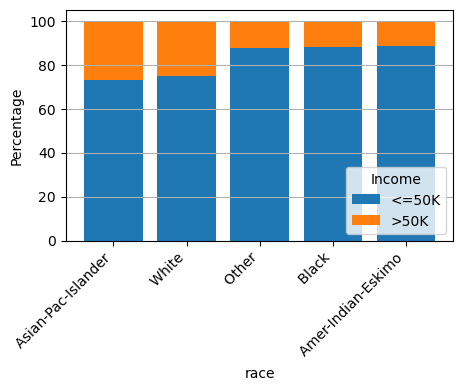

In [287]:
labelPercentagePlot("race",df,(5,3))

this pattern is similar to what studies have found where white is normally higher than minority groups other than asian

<Axes: xlabel='race'>

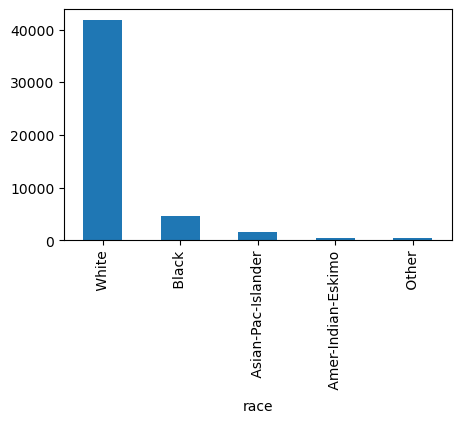

In [288]:
df["race"].value_counts().plot(kind="bar",figsize=(5,3))

In [289]:
#grouping races together along their income groups
df["race"].replace({" Asian-Pac-Islander":"White-Asian-Pac-Islander",
                    " White":"White-Asian-Pac-Islander",
                    " Black":"Black-Amer-Indian-Eskimo-Other",
                    " Amer-Indian-Eskimo":"Black-Amer-Indian-Eskimo-Other",
                    " Other":"Black-Amer-Indian-Eskimo-Other",
                    },inplace=True)

In [290]:
df["race"].value_counts(normalize=True)*100

race
White-Asian-Pac-Islander          88.616853
Black-Amer-Indian-Eskimo-Other    11.383147
Name: proportion, dtype: float64

depsite the impact race has on income in america, as has been shown in studies, i will have to drop it as the data is just too imbalanced and not representative of current demographics in the US

In [291]:
df.drop("race",axis=1,inplace=True)

<h3>2.11 sex </h3>
Due to the gender pay gap sex is a strong indicator of income and so it will be kept

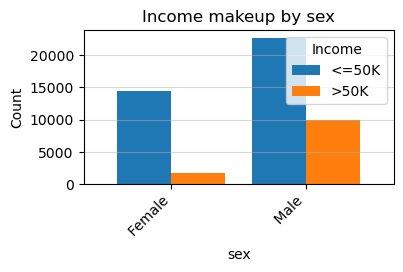

In [292]:
labelPlot("sex",df,"Income makeup by sex",(4,2))

In [293]:
df.groupby("sex")["label"].value_counts(normalize=True) * 100

sex      label
 Female  <=50K    89.074280
         >50K     10.925720
 Male    <=50K    69.604928
         >50K     30.395072
Name: proportion, dtype: float64

<h3>2.12 capital-gain </h3>
I will engineer a new feature called capital which will either be have or not for wether the person has any capital. i have assumed that anyone who has had any capital gain or loss will be someone who has some investments and so they will have some disposable income and thus they will have a higher income, this prediction is reflected in the data

In [294]:
df["capital"] = "have not"

#Update "capital" column based on conditions
df.loc[(df["capital-gain"] != 0) | (df["capital-loss"] != 0), "capital"] = "have"

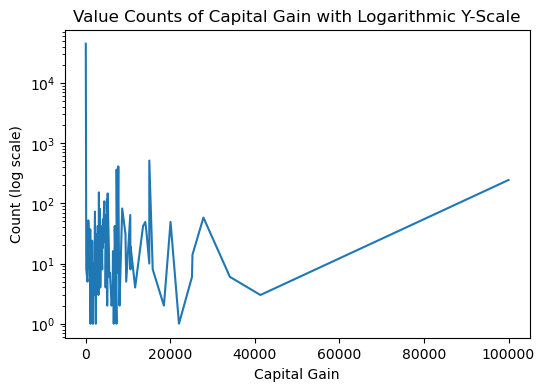

In [295]:
#Plot the value counts with a logarithmic y-scale
ax = df["capital-gain"].value_counts().sort_index().plot(kind="line",logy=True,figsize=(6,4))

#Set plot labels and title
ax.set_xlabel("Capital Gain")
ax.set_ylabel("Count (log scale)")
plt.title("Value Counts of Capital Gain with Logarithmic Y-Scale")

#Show the plot
plt.show()

In [296]:
#Define bins
bins = [-1, 0, 5000, 10000, 15000, np.inf]
labels = ["No Gain", "Low Gain", "Moderate Gain", "High Gain", "Very High Gain"]

#Apply binning
df["capital-gain"] = pd.cut(df["capital-gain"], bins=bins, labels=labels)

<Axes: ylabel='capital-gain'>

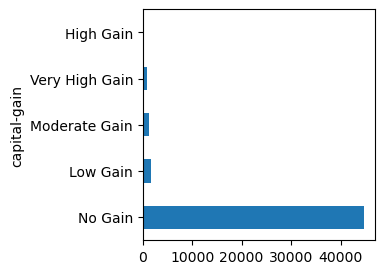

In [297]:
df["capital-gain"].value_counts().plot(kind="barh",figsize=(3,3))

label               <=50K       >50K
capital-gain                        
No Gain         79.467137  20.532863
Low Gain        82.099937  17.900063
Moderate Gain   17.084282  82.915718
High Gain        3.636364  96.363636
Very High Gain   1.094092  98.905908


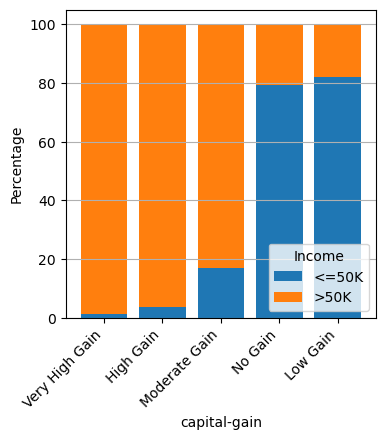

In [298]:
labelPercentagePlot("capital-gain",df,(4,4))

In [299]:
df["capital-gain"].value_counts()

capital-gain
No Gain           44777
Low Gain           1581
Moderate Gain      1317
Very High Gain      914
High Gain           220
Name: count, dtype: int64

there are clear categories among the data, but they are very imbalanced

<h3>2.13 capital-loss </h3>

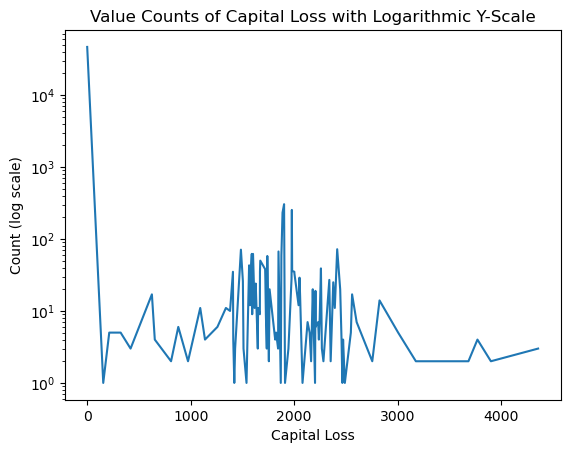

In [300]:
#Plot the value counts with a logarithmic y-scale
ax = df["capital-loss"].value_counts().sort_index().plot(kind="line",logy=True)

#Set plot labels and title
ax.set_xlabel("Capital Loss")
ax.set_ylabel("Count (log scale)")
plt.title("Value Counts of Capital Loss with Logarithmic Y-Scale")

#Show the plot
plt.show()


In [301]:
df["capital-loss"] = df["capital-loss"].astype(int)

In [302]:
#Define bins
bins = [-1, 0, np.inf]
labels = ["No Loss", "Low Loss"]

#Apply binning
df["capital-loss"] = pd.cut(df["capital-loss"], bins=bins, labels=labels)

<Axes: ylabel='capital-loss'>

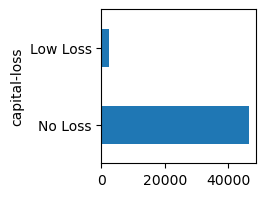

In [303]:
df["capital-loss"].value_counts().plot(kind="barh",figsize=(2,2))

label             <=50K       >50K
capital-loss                      
No Loss       77.342675  22.657325
Low Loss      49.890399  50.109601


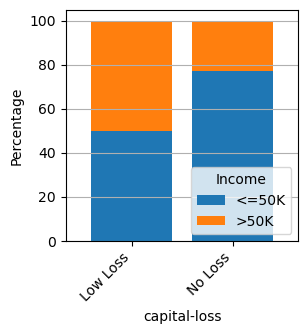

In [304]:
labelPercentagePlot("capital-loss",df,(3,3))

inital thoughts are high capital loss would correlate with low income but its inverse, probably because people with higher income have more to invest and so they are able to lose more, whereas people with lower income dont have disposable income to invest and so they cant lose as much, also people with higher income may be more likely to make more risky financial decisions as they can make the money back

In [305]:
df.drop("capital-loss", axis=1, inplace=True)
df.drop("capital-gain", axis=1, inplace=True)

<Axes: xlabel='capital'>

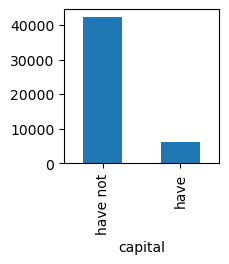

In [306]:
df["capital"].value_counts().plot(kind="bar",figsize=(2,2))

<h3>2.14 hours-per-week </h3>
grouped into 4 bins as the categories before were continous and too spread out

In [307]:
bins = [0, 39, 41, np.inf]
labels = [">40", "40", "<40"]

#Apply binning
df["hours-per-week"] = pd.cut(df["hours-per-week"], bins=bins, labels=labels)


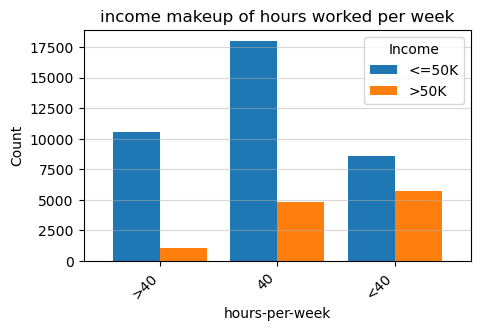

In [308]:
labelPlot("hours-per-week",df,"income makeup of hours worked per week",(5,3))

In [309]:
df["hours-per-week"].value_counts()

hours-per-week
40     22852
<40    14287
>40    11670
Name: count, dtype: int64

<h3>2.15 native-country </h3>
the data is useful but far too infrequent for countries other than US, i have tried merging into continent but its still too infrequent

In [310]:
df["native-country"].value_counts(normalize=True)*100

native-country
 United-States                 89.737548
 Mexico                         1.948411
 ?                              1.755824
 Philippines                    0.602348
 Germany                        0.422053
 Puerto-Rico                    0.376980
 Canada                         0.372882
 El-Salvador                    0.317564
 India                          0.309369
 Cuba                           0.282735
 England                        0.260198
 China                          0.249954
 South                          0.235612
 Jamaica                        0.217173
 Italy                          0.215124
 Dominican-Republic             0.211027
 Japan                          0.188490
 Guatemala                      0.180295
 Poland                         0.178246
 Vietnam                        0.176197
 Columbia                       0.174148
 Haiti                          0.153660
 Portugal                       0.137270
 Taiwan                         0.133172
 

label                             <=50K       >50K
native-country                                    
 ?                            74.329055  25.670945
 Cambodia                     67.857143  32.142857
 Canada                       65.384615  34.615385
 China                        70.491803  29.508197
 Columbia                     95.294118   4.705882
 Cuba                         75.362319  24.637681
 Dominican-Republic           95.145631   4.854369
 Ecuador                      86.666667  13.333333
 El-Salvador                  92.903226   7.096774
 England                      62.992126  37.007874
 France                       57.894737  42.105263
 Germany                      71.844660  28.155340
 Greece                       63.265306  36.734694
 Guatemala                    96.590909   3.409091
 Haiti                        88.000000  12.000000
 Holand-Netherlands          100.000000        NaN
 Honduras                     90.000000  10.000000
 Hong                         7

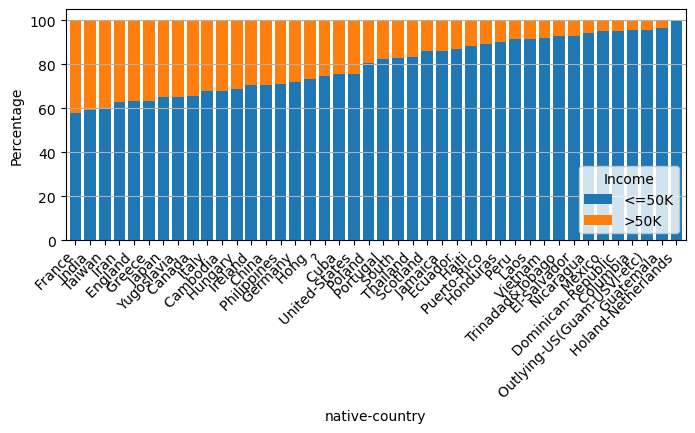

In [311]:
labelPercentagePlot("native-country",df,(8,3))

In [312]:
country_continent_mapping = {
    " United-States": "United-States",
    " Cuba": "North America",
    " Jamaica": "North America",
    " India": "Asia",
    " ?": "Unknown",
    " Mexico": "North America",
    " South": "Unknown",
    " Puerto-Rico": "North America",
    " Honduras": "North America",
    " England": "Europe",
    " Canada": "North America",
    " Germany": "Europe",
    " Iran": "Asia",
    " Philippines": "Asia",
    " Italy": "Europe",
    " Poland": "Europe",
    " Columbia": "South America",
    " Cambodia": "Asia",
    " Thailand": "Asia",
    " Ecuador": "South America",
    " Laos": "Asia",
    " Taiwan": "Asia",
    " Haiti": "North America",
    " Portugal": "Europe",
    " Dominican-Republic": "North America",
    " El-Salvador": "North America",
    " France": "Europe",
    " Guatemala": "North America",
    " China": "Asia",
    " Japan": "Asia",
    " Yugoslavia": "Europe",
    " Peru": "South America",
    " Outlying-US(Guam-USVI-etc)": "Unknown",
    " Scotland": "Europe",
    " Trinadad&Tobago": "North America",
    " Greece": "Europe",
    " Nicaragua": "North America",
    " Vietnam": "Asia",
    " Hong": "Asia",
    " Ireland": "Europe",
    " Hungary": "Europe",
    " Holand-Netherlands": "Europe"
}


df["native-country"].replace(country_continent_mapping,inplace=True)
df["native-country"].value_counts(normalize=True)*100

native-country
United-States    89.737548
North America     4.257412
Unknown           2.038558
Asia              2.007826
Europe            1.598066
South America     0.360589
Name: proportion, dtype: float64

label               <=50K       >50K
native-country                      
Asia            70.000000  30.000000
Europe          70.512821  29.487179
North America   89.701636  10.298364
South America   92.045455   7.954545
United-States   75.589041  24.410959
Unknown         75.778894  24.221106


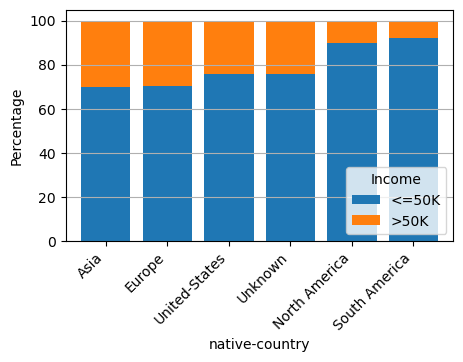

In [313]:
labelPercentagePlot("native-country",df,(5,3))

<Axes: ylabel='native-country'>

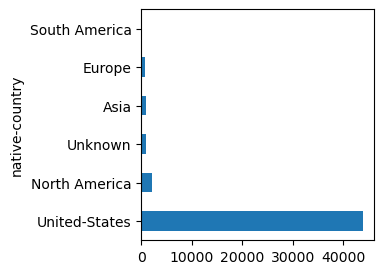

In [314]:
df["native-country"].value_counts().plot(kind="barh",figsize=(3,3))

although data has clear split not enough for it to be useful

In [315]:
df.drop("native-country", axis=1, inplace=True)

<h3>2.16 Feature encoding</h3>

In [316]:
#Encoding the labels from <=50K to 0 and >50K to 1
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])

In [317]:
#encoding age categories by their corresponding ages
df["age"].replace(age_categories,inplace=True)

In [318]:
#encoding workclass by order of income
avg_label = df.groupby("workclass")["label"].mean().sort_values(ascending=False)
work_order = avg_label.index.tolist()
work_mapping = {work: i for i, work in enumerate(work_order)}

df["workclass"] = df["workclass"].map(work_mapping)

In [319]:
#encoding marriage by income
marriage_order = [" Never-married","Separated","Married"]

#Create an OrdinalEncoder instance with the specified order
marriage_encoder = OrdinalEncoder(categories=[marriage_order], dtype=int)

#Fit and transform the "education" column
df["marital-status"] = marriage_encoder.fit_transform(df[["marital-status"]])

In [320]:
#encoding occupation by income
avg_label = df.groupby("occupation")["label"].mean().sort_values(ascending=False)
occupation_order = avg_label.index.tolist()
occupation_mapping = {occupation: i for i, occupation in enumerate(occupation_order)}

df["occupation"] = df["occupation"].map(occupation_mapping)

In [321]:
#encoding education by eduction level
education_order = ["Less than High School", "High School Graduate", "Some College", "Associate Degree", "Bachelor Degree", "Master Degree", "Doctorate"]

#Create an OrdinalEncoder instance with the specified order
education_encoder = OrdinalEncoder(categories=[education_order], dtype=int)

#Fit and transform the "education" column
df["education"] = education_encoder.fit_transform(df[["education"]])

In [322]:
#encoding living situtio
df["living-situation"] = label_encoder.fit_transform(df["living-situation"])

In [323]:
#encoding sex
df["sex"] = label_encoder.fit_transform(df["sex"])

In [324]:
#encoding capital
df["capital"] = label_encoder.fit_transform(df["capital"])

In [325]:
#encoding hours worked by income
avg_label = df.groupby("hours-per-week")["label"].mean().sort_values(ascending=False)
hours_order = avg_label.index.tolist()
hours_mapping = {hours: i for i, hours in enumerate(hours_order)}

df["hours-per-week"] = df["hours-per-week"].map(hours_mapping)

<h3>2.17 Summary plot of formatted features </h3>
creating a summary plot of the final features before they are used in the models

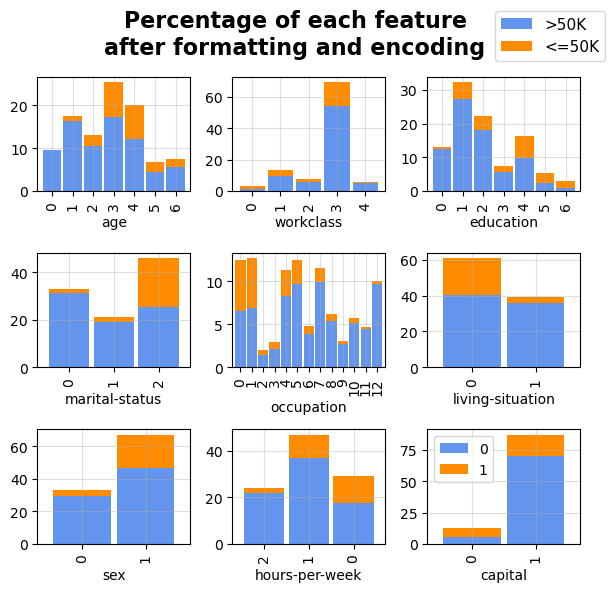

In [326]:
#Exclude the "label" column
columns_to_plot = [col for col in df.columns if col != "label"]

#Create a 9x9 grid
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))

axes = axes.flatten()
fig.suptitle("Percentage of each feature\nafter formatting and encoding",fontweight="bold",fontsize=16)

#Plot each bar chart for each feature
for i, col in enumerate(columns_to_plot):
    grouped_data = df.groupby([col, "label"]).size().unstack().fillna(0) / len(df["label"]) *100
    grouped_data.plot(kind="bar", stacked=True, width=0.9, color=["cornflowerblue", "darkorange"], ax=axes[i], legend=False)
    axes[i].grid(True, alpha=0.4)

fig.legend(labels=[">50K", "<=50K"], loc="upper right",bbox_to_anchor=(1.03, 0.99),fontsize=11)

plt.legend()
plt.tight_layout()
plt.show()

you can see that there are few categories where the label 1 is dominant, the data is very skewed and a bias towards label 1 will be needed

<h3>2.18 Train Validate Test Split</h3>
Splitting data into 2 sections, one for testing and one for training

In [327]:
y = df["label"] #target
X = df.drop("label", axis=1) #features

In [328]:
#Splitting the data into 80% training, 10% validation, and 10% testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

<h2>3. Model Selection</h2>
Selecting models and applying them to the data

<h3>3.1 Untuned models</h3>
seeing how the untuned models perform

<h4>3.1.1 Linear regression</h4>

In [329]:
#Create the Linear Regression model
linear_model = LinearRegression()

#Train the model
linear_model.fit(X_train, y_train)

#Make predictions on the test set
linear_validation_predictions = linear_model.predict(X_validation)

#Convert continuous predictions to binary categorisations
threshold = 0.5
linear_validation_predictions = (linear_validation_predictions >= threshold).astype(int)
linear_validation_predictions


array([1, 0, 0, ..., 0, 0, 0])

<h4>3.1.2 Logistic Regression</h4>

In [330]:
#Create the Logistic Regression model using the hyperparameters
logistic_model = LogisticRegression()

#train the model
logistic_model.fit(X_train, y_train)

#Make predictions on the test set
logistic_validation_predictions = logistic_model.predict(X_validation)

<h3>3.2 Untuned model evalutaion</h3>

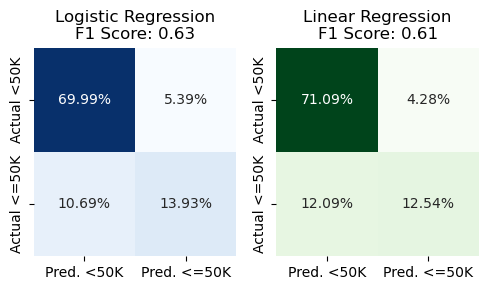

In [331]:
#Create confusion matrices
logistic_conf_matrix = confusion_matrix(y_validation, logistic_validation_predictions)
linear_conf_matrix = confusion_matrix(y_validation, (linear_validation_predictions >= threshold).astype(int))

#Calculate F1 score
logistic_f1 = f1_score(y_validation, logistic_validation_predictions)
linear_f1 = f1_score(y_validation, (linear_validation_predictions >= threshold).astype(int))

#Plotting the confusion matrix for Logistic Regression
plt.figure(figsize=(5, 3))
plt.subplot(1, 2, 1)
sns.heatmap(logistic_conf_matrix / logistic_conf_matrix.sum(), annot=True, fmt=".2%", cmap="Blues", cbar=False,
            xticklabels=["Pred. <50K", "Pred. <=50K"],
            yticklabels=["Actual <50K", "Actual <=50K"])
plt.title(f"Logistic Regression\nF1 Score: {logistic_f1:.2f}")

#Plotting the confusion matrix for Linear Regression
plt.subplot(1, 2, 2)
sns.heatmap(linear_conf_matrix / linear_conf_matrix.sum(), annot=True, fmt=".2%", cmap="Greens", cbar=False,
            xticklabels=["Pred. <50K", "Pred. <=50K"],
            yticklabels=["Actual <50K", "Actual <=50K"])
plt.title(f"Linear Regression\nF1 Score: {linear_f1:.2f}")

plt.tight_layout()
plt.show()

<h3>3.3 Hyperparameter Tuning</h3>
Tuning the models to have better F1 and Cohen scores

<h4>3.3.1 Linear Tuning</h4>

In [332]:
#Defining linear regression parameters
linear_regression_parameters = {
    "fit_intercept": True,   #Whether to calculate the intercept for this model
    "n_jobs": None           #Number of jobs to use for the computation (set to None to use all available)
}
#Create the Linear Regression model
linear_model_tuned = LinearRegression(**linear_regression_parameters)

#Train the model
linear_model_tuned.fit(X_train, y_train)

#Make predictions on the test set
tuned_linear_predictions = linear_model_tuned.predict(X_test)

#Convert continuous predictions to binary outcomes using a threshold (e.g., 0.5)
tuned_threshold = 0.35
tuned_linear_predictions = (tuned_linear_predictions >= tuned_threshold).astype(int)


<h4> 3.3.2 Logistic Tuning</h4>

In [333]:
#defining the logistic hyperparameters
logistic_hyperparameters = {
    "penalty": "l2",
    "C": 0.01,
    "solver": "liblinear",
    "max_iter": 50,
    "fit_intercept": True,
    "class_weight": "balanced",
    "random_state": 1
}
#solver: Literal["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"] = "lbfgs",

#Create the Logistic Regression model using the hyperparameters
logistic_model_tuned = LogisticRegression(**logistic_hyperparameters)

#train the model
logistic_model_tuned.fit(X_train, y_train)

#Make predictions on the test set
tuned_logistic_predictions = logistic_model_tuned.predict(X_test)


c:\Users\bthug\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


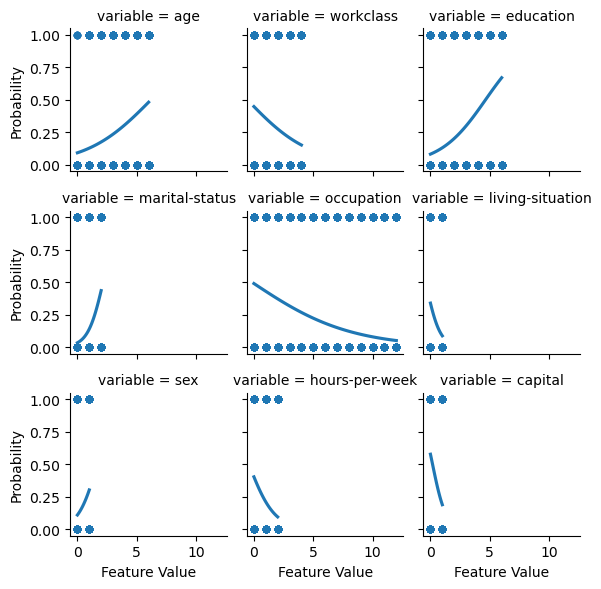

In [334]:
#Convert the DataFrame to a long format suitable for seaborn
df_long = pd.melt(pd.concat([X_train, y_train], axis=1), id_vars=["label"])

#Plot logistic regression curves for all features
g = sns.lmplot(x="value", y="label", col="variable", col_wrap=3, data=df_long, logistic=True, ci=None, scatter_kws={"s": 20}, height=2, aspect=1)
g.set(xlabel="Feature Value", ylabel="Probability")
plt.show()

<h2>4. Model Analysis</h2>
Analysing different models

4.1 confusion matrix and f1 score

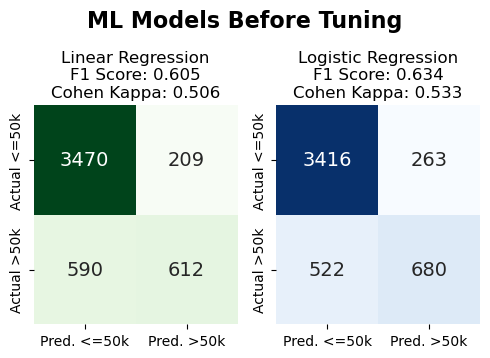

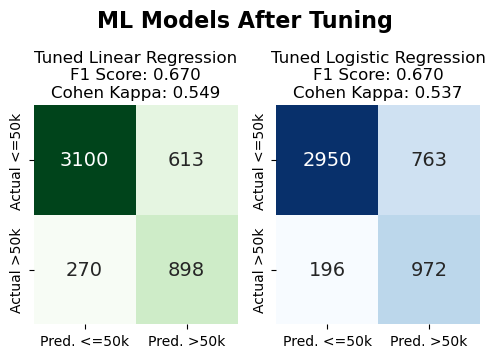

In [335]:
#Create confusion matrices
logistic_conf_matrix = confusion_matrix(y_validation, logistic_validation_predictions)
linear_conf_matrix = confusion_matrix(y_validation, linear_validation_predictions)
tuned_logistic_cm = confusion_matrix(y_test, tuned_logistic_predictions)
tuned_linear_cm = confusion_matrix(y_test, tuned_linear_predictions)

#Calculate F1 score
logistic_f1 = f1_score(y_validation, logistic_validation_predictions)
linear_f1 = f1_score(y_validation, linear_validation_predictions)
tuned_logistic_f1 = f1_score(y_test, tuned_logistic_predictions)
tuned_linear_f1 = f1_score(y_test, tuned_linear_predictions)

logistic_kappa = cohen_kappa_score(y_validation, logistic_validation_predictions)
linear_kappa = cohen_kappa_score(y_validation, linear_validation_predictions)
tuned_logistic_kappa = cohen_kappa_score(y_test, tuned_logistic_predictions)
tuned_linear_kappa = cohen_kappa_score(y_test, tuned_linear_predictions)

annot_font_size = 14
#Plotting for ML models before tuning
plt.figure(figsize=(5, 6))
plt.suptitle("ML Models Before Tuning", fontsize=16,fontweight="bold")

#Untuned Linear Regression
plt.subplot(2, 2, 1)
sns.heatmap(linear_conf_matrix, annot=True, fmt="", cmap="Greens", cbar=False,
            annot_kws={"size": annot_font_size},
            xticklabels=["Pred. <=50k", "Pred. >50k"],
            yticklabels=["Actual <=50k", "Actual >50k"])
plt.title(f"Linear Regression\nF1 Score: {linear_f1:.3f}\nCohen Kappa: {linear_kappa:.3f}")

#Untuned Logistic Regression
plt.subplot(2, 2, 2)
sns.heatmap(logistic_conf_matrix, annot=True, fmt="", cmap="Blues", cbar=False,
            annot_kws={"size": annot_font_size},
            xticklabels=["Pred. <=50k", "Pred. >50k"],
            yticklabels=["Actual <=50k", "Actual >50k"])
plt.title(f"Logistic Regression\nF1 Score: {logistic_f1:.3f}\nCohen Kappa: {logistic_kappa:.3f}")

plt.tight_layout()  #Adjust the layout to accommodate the suptitle
plt.show()

#Plotting for ML models after tuning
plt.figure(figsize=(5, 6))
plt.suptitle("ML Models After Tuning", fontsize=16,fontweight="bold")

#Tuned Linear Regression
plt.subplot(2, 2, 1)
sns.heatmap(tuned_linear_cm, annot=True, fmt="", cmap="Greens", cbar=False,
            annot_kws={"size": annot_font_size},
            xticklabels=["Pred. <=50k", "Pred. >50k"],
            yticklabels=["Actual <=50k", "Actual >50k"])
plt.title(f"Tuned Linear Regression\nF1 Score: {tuned_linear_f1:.3f}\nCohen Kappa: {tuned_linear_kappa:.3f}")

#Tuned Logistic Regression
plt.subplot(2, 2, 2)
sns.heatmap(tuned_logistic_cm, annot=True, fmt="", cmap="Blues", cbar=False,
            annot_kws={"size": annot_font_size},
            xticklabels=["Pred. <=50k", "Pred. >50k"],
            yticklabels=["Actual <=50k", "Actual >50k"])
plt.title(f"Tuned Logistic Regression\nF1 Score: {tuned_logistic_f1:.3f}\nCohen Kappa: {tuned_logistic_kappa:.3f}")

plt.tight_layout()  #Adjust the layout to accommodate the suptitle
plt.show()

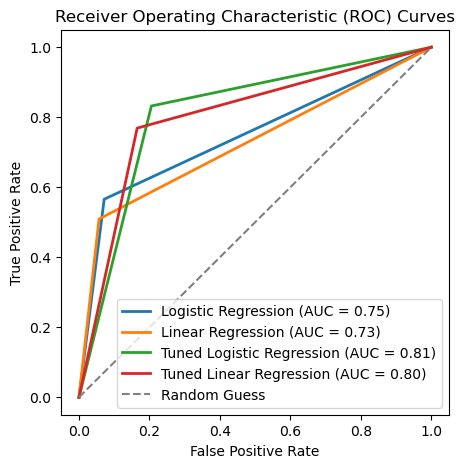

In [336]:
#Logistic Regression
logistic_fpr, logistic_tpr, _ = roc_curve(y_validation, logistic_validation_predictions)
logistic_auc = auc(logistic_fpr, logistic_tpr)

# Linear Regression
linear_fpr, linear_tpr, _ = roc_curve(y_validation, linear_validation_predictions)
linear_auc = auc(linear_fpr, linear_tpr)

# Tuned Logistic Regression
tuned_logistic_fpr, tuned_logistic_tpr, _ = roc_curve(y_test, tuned_logistic_predictions)
tuned_logistic_auc = auc(tuned_logistic_fpr, tuned_logistic_tpr)

# Tuned Linear Regression
tuned_linear_fpr, tuned_linear_tpr, _ = roc_curve(y_test, tuned_linear_predictions)
tuned_linear_auc = auc(tuned_linear_fpr, tuned_linear_tpr)

# Plot ROC curves
plt.figure(figsize=(5, 5))
plt.plot(logistic_fpr, logistic_tpr, label=f'Logistic Regression (AUC = {logistic_auc:.2f})', linewidth=2)
plt.plot(linear_fpr, linear_tpr, label=f'Linear Regression (AUC = {linear_auc:.2f})', linewidth=2)
plt.plot(tuned_logistic_fpr, tuned_logistic_tpr, label=f'Tuned Logistic Regression (AUC = {tuned_logistic_auc:.2f})', linewidth=2)
plt.plot(tuned_linear_fpr, tuned_linear_tpr, label=f'Tuned Linear Regression (AUC = {tuned_linear_auc:.2f})', linewidth=2)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend()
plt.show()